# Generación de covariables
- Identificar palabras clave
- Contabilizar componentes sintácticos

In [59]:
import pandas as pd
# Cargar el archivo Excel
file_path = 'Rest_Mex_2022_Sentiment_Analysis_Track_Train.xlsx'
df = pd.read_excel(file_path)

- Funcion para preprocesamiento de texto

In [60]:
import spacy
import unidecode

# Cargar el modelo en español de spaCy
nlp = spacy.load("es_core_news_sm")

# Función para normalizar el texto usando spaCy
def normalize_text(text):
    # Cast a str
    text = str(text)
    # Convertir a minúsculas
    text = text.lower()
    # Quitar acentos
    text = unidecode.unidecode(text)
    # Procesar el texto con spaCy
    doc = nlp(text)
    # Eliminar stop words y puntuación, y realizar lematización
    text = ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    return text

Preprocesamiento del texto en paralelo

In [61]:
from concurrent.futures import ThreadPoolExecutor

def parallel_processing_threads(data, func):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(func, data))
    return results

# Reemplazando los valores NaN con cadenas vacías en la columna "Opinion"
df['Opinion'].fillna('', inplace=True)

# Normaliza el dataframe en paralelo
df['Opinion'] = parallel_processing_threads(df['Opinion'], normalize_text)

- Categorizar las opiniones

In [62]:
# Separar las opiniones por categoría
categories = df['Attraction'].unique()
#print(categories)

Nube de palabras mas comunes por categoria

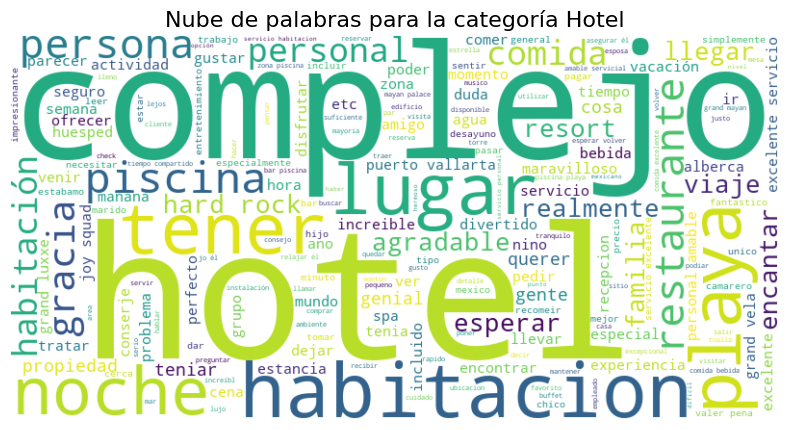

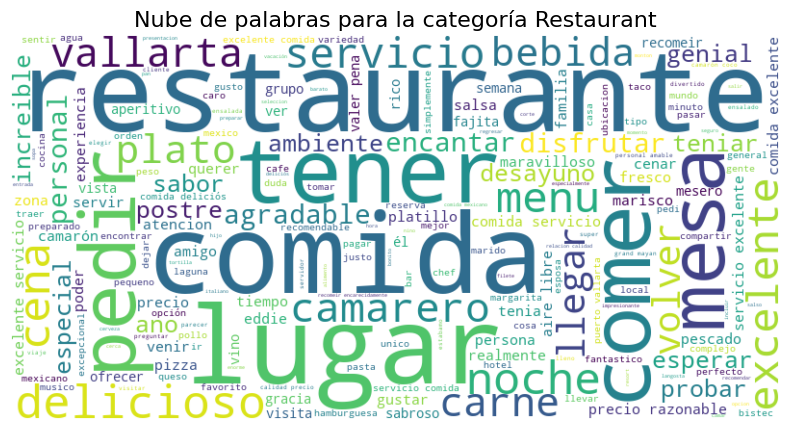

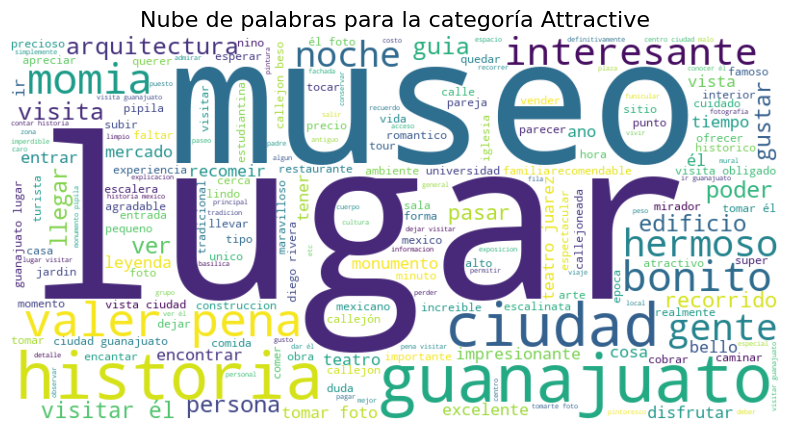

In [63]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear una nube de palabras para cada categoría e imprimirlas individualmente
for i, category in enumerate(categories):
    text = ' '.join(df[df['Attraction'] == category]['Opinion'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nube de palabras para la categoría {category}', fontsize=16)
    plt.axis('off')
    plt.show()

Obtener las 50 palabras mas frecuentes, por categoria

In [64]:
from collections import Counter

top_50_words_by_category = {}

for category in categories:
    words = [word for opinion in df[df['Attraction'] == category]['Opinion'] for word in opinion.split()]
    most_common_words = [word for word, _ in Counter(words).most_common(50)]
    top_50_words_by_category[category] = most_common_words

Palabras más frecuentes por categoría y por variable sintáctica

In [65]:
import spacy

nlp = spacy.load("es_core_news_sm")
data = {}

for category, words in top_50_words_by_category.items():
    text = ' '.join(words)
    doc = nlp(text)
  
    adjetivos = [token.text for token in doc if token.pos_ == 'ADJ']
    verbos = [token.text for token in doc if token.pos_ == 'VERB']
    sustantivos = [token.text for token in doc if token.pos_ == 'NOUN']
    ner = [ent.text for ent in doc.ents]

    data[f'Adjetivos {category}'] = adjetivos
    data[f'Verbos {category}'] = verbos
    data[f'Sustantivos {category}'] = sustantivos
    data[f'NER {category}'] = ner

Agregando las nuevas columnas al dataframe

In [66]:
for category in categories:
    for component in ['Adjetivos', 'Verbos', 'Sustantivos', 'NER']:
        col_name = f"{component} {category} Count"
        words_to_count = data[f"{component} {category}"]
        
        df[col_name] = df['Opinion'].apply(lambda x: sum(word in x.split() for word in words_to_count))

Obetniendo las nuevas covariables

In [67]:
# Función para crear un vector a partir de las columnas especificadas
def create_vector(row, columns):
    return [row[col] for col in columns]

# Lista de las nuevas columnas añadidas previamente
new_columns = []
for category in categories:
    for component in ['Adjetivos', 'Verbos', 'Sustantivos', 'NER']:
        new_columns.append(f"{component} {category} Count")

# Crear la nueva columna conteniendo los vectores
df['Feature_Vector'] = df.apply(lambda row: create_vector(row, new_columns), axis=1)

# Verificar las primeras filas del DataFrame modificado para asegurarse de que la nueva columna ha sido añadida
#df.head()

- Entrenar un modelo naive bayes con las nuevas covariables

In [70]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# Etiquietas
y = df['Attraction']

# Convertir la columna de vectores de características a una lista de listas
X = df['Feature_Vector'].tolist()

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el clasificador Naive Bayes
nb = GaussianNB()

# Entrenar el clasificador
nb.fit(X_train, y_train)

GaussianNB()

Calcular acc y matriz de confusion como mapa de calor

Accuracy: 60.55%


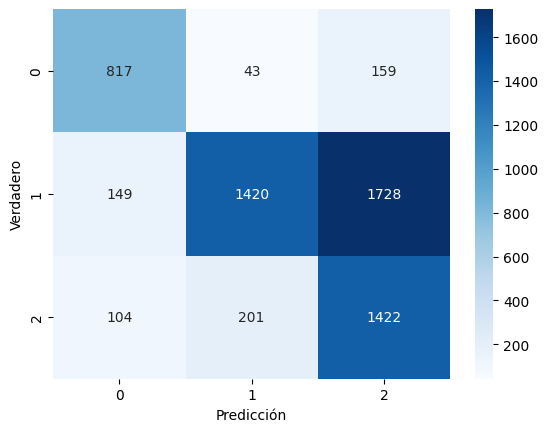

In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Hacer predicciones en el conjunto de prueba
y_pred = nb.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión como un mapa de calor
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()